In [1]:
# import basics and ahs specific components
import numpy as np
import matplotlib.pyplot as plt
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from ahs_utils import show_register, show_global_drive, show_final_avg_density, get_drive
from braket.devices import LocalSimulator
from braket.aws import AwsDevice 

# Sets the device to Aquila - QuEra's first public QPU
qpu = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")

# Gives us the capabilities of Aquila
capabilities = qpu.properties.paradigm
rydberg = capabilities.rydberg
rydberg

Rydberg(c6Coefficient=Decimal('5.42E-24'), rydbergGlobal=RydbergGlobal(rabiFrequencyRange=(Decimal('0.0'), Decimal('15800000.0')), rabiFrequencyResolution=Decimal('400.0'), rabiFrequencySlewRateMax=Decimal('250000000000000.0'), detuningRange=(Decimal('-125000000.0'), Decimal('125000000.0')), detuningResolution=Decimal('0.2'), detuningSlewRateMax=Decimal('2500000000000000.0'), phaseRange=(Decimal('-99.0'), Decimal('99.0')), phaseResolution=Decimal('5E-7'), timeResolution=Decimal('1E-9'), timeDeltaMin=Decimal('5E-8'), timeMin=Decimal('0.0'), timeMax=Decimal('0.000004')))

# Two-Leg Ladder - Batched

In this notebook, we show how to take advantage of parallelization inherent to the neutral atom architecture. We use the previous two-leg ladder to demonstrate.

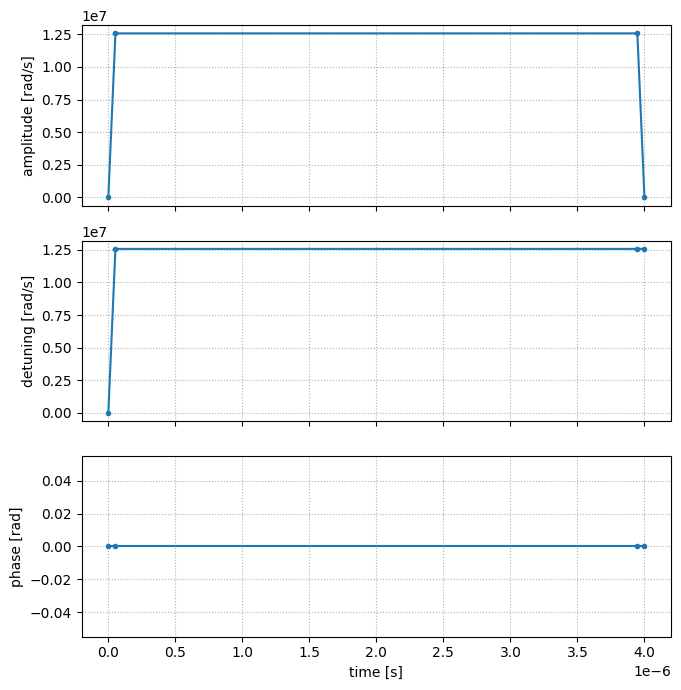

In [2]:
# Hamiltonian drive construction - same as previous notebook


total_time = 4.0e-6 # total evolution time in s

# The machine must start and end with Omega at 0. Therefore, we must leave time at the beginning and end
#  of the simulation for ramping Omega to our desired value and then ramping back down to 0. There is a finite
#  speed at which Omega can be changed, called the slew rate. We define that below and then use it to determine
#  the smallest possible ramp up/down time given our desired constant Omega
max_slew = float(rydberg.rydbergGlobal.rabiFrequencySlewRateMax) # rad/s^2 advised to only use 95% of max for now
omega_min= 0  # rad/s
omega_max = np.pi*4.0e6 # rad/s
ramp_time = omega_max/(max_slew*0.95) # microseconds

# The Hamiltonian drive is constructed in terms of time points where the parameters of the analog device are changed.
# To implement evolution under constant Omega, we start at time t_0=0 then ramp up to desired Omega.
#  The desired Omega is reached at t_1=ramp_time defined above. We then evolve for the rest of the possible time
#  minus the time needed to ramp down. This means we will have a t_2=total_time-ramp_time and end with our final time
#  t_3=total_time. We make an array out of these time points below.
time_points = [0, ramp_time, total_time-ramp_time, total_time]

# For this simulation, we want the detuning to exactly track omega. It is entirely possible to do something different, but
#  we need to make sure the points in time at which parameters are changing is defined in the above array.
detuning_min = omega_min
detuning_max = omega_max 

# We now construct arrays of Omega and Detuning values that match the time_points above.
omega_values = [omega_min, omega_max, omega_max, omega_min]  # piecewise linear
detuning_values = [detuning_min, detuning_max, detuning_max, detuning_max]  # piecewise linear

# For this simulation, set phase to 0 at all time.
phase_values = [0, 0, 0, 0]  # piecewise constant

# Define the drive via the following function that takes in all previously defined arrays.
const_drive = get_drive(time_points, omega_values, detuning_values, phase_values)

# We can view the drive pattern by running the below function.
show_global_drive(const_drive)

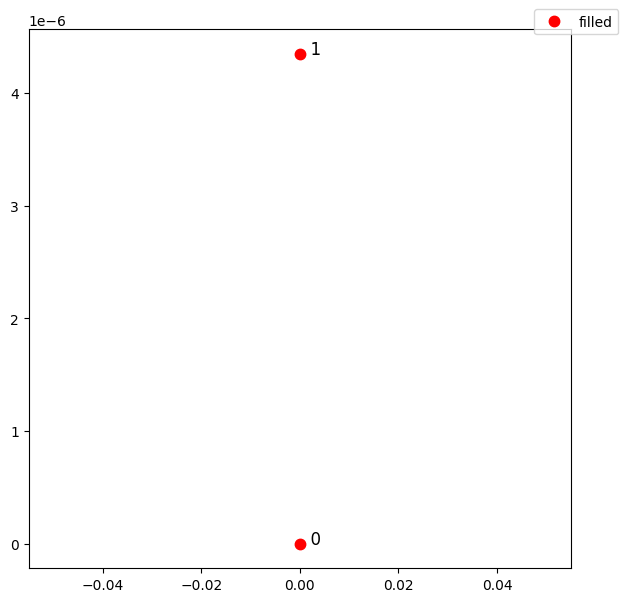

can place 5 copies wide and 4 copies tall


In [5]:
# On the neutral atom platform, we can place many instances of our two-leg ladder in the simulation window.
#  We want to place the instances such that they are separated enough and therefore will not interact strongly.
#  This is possible because of the 1/r^6 interaction between the excited Rydberg states.

# First, copy the atom construction from before. This represents the arrangement we will parallelize.
c6 = float(rydberg.dict()["c6Coefficient"])
Rb = (c6/omega_max)**(1/6)

two_leg_ladder = AtomArrangement()
num_rungs = 1
aspect_ratio = 0.5
inter_rung_spacing = Rb/2.0 # spacing between the two atoms on a single rung (same as scale in Bloqade)
outer_rung_spacing = inter_rung_spacing*aspect_ratio

for i in range(num_rungs):
    for j in range(2):
        two_leg_ladder.add([i*outer_rung_spacing, j*inter_rung_spacing])
show_register(two_leg_ladder)


# Now, construct the parameters for the simulatable window - setting both the total space available
#  in the simulation window as well as the spacing between the instances.

x_min = min(*[site.coordinate[0] for site in two_leg_ladder])
x_max = max(*[site.coordinate[0] for site in two_leg_ladder])
y_min = min(*[site.coordinate[1] for site in two_leg_ladder])
y_max = max(*[site.coordinate[1] for site in two_leg_ladder])

single_problem_width = x_max - x_min
single_problem_height = y_max - y_min

# get values from device capabilities
field_of_view_width = qpu.properties.paradigm.lattice.area.width
field_of_view_height = qpu.properties.paradigm.lattice.area.height
n_site_max = qpu.properties.paradigm.lattice.geometry.numberSitesMax

# set distance between batches to be 3 x scale
batch_distance = 3.0*inter_rung_spacing
# setting up a grid of problems filling the total area
n_width = int(float(field_of_view_width)   // (single_problem_width  + batch_distance))
n_height = int(float(field_of_view_height) // (single_problem_height + batch_distance))
print("can place " + str(n_width) + " copies wide and " + str(n_height) + " copies tall")

In [6]:
# With our current settings, we can place 20 instances of the two atom arrangement in the simulation
#  window.

# Now, let's create a dictionary that will help us keep track of the parallel instances. This will make
#  it easier to implement the collect the individual measurements into a parallelized measurement representing
#  a single two-atom configuration.

batch_mapping = dict()
parallel_two_leg_ladder = AtomArrangement()

atom_number = 0 #counting number of atoms added

for ix in range(n_width):
    x_shift = ix * (single_problem_width   + batch_distance)

    for iy in range(n_height):    
        y_shift = iy * (single_problem_height  + batch_distance)

        # reached the maximum number of batches possible given n_site_max
        if atom_number + len(two_leg_ladder) > n_site_max: break 

        atoms = []
        for site in two_leg_ladder:
            new_coordinate = (x_shift + site.coordinate[0], y_shift + site.coordinate[1])
            parallel_two_leg_ladder.add(new_coordinate,site.site_type)

            atoms.append(atom_number)

            atom_number += 1

        batch_mapping[(ix,iy)] = atoms

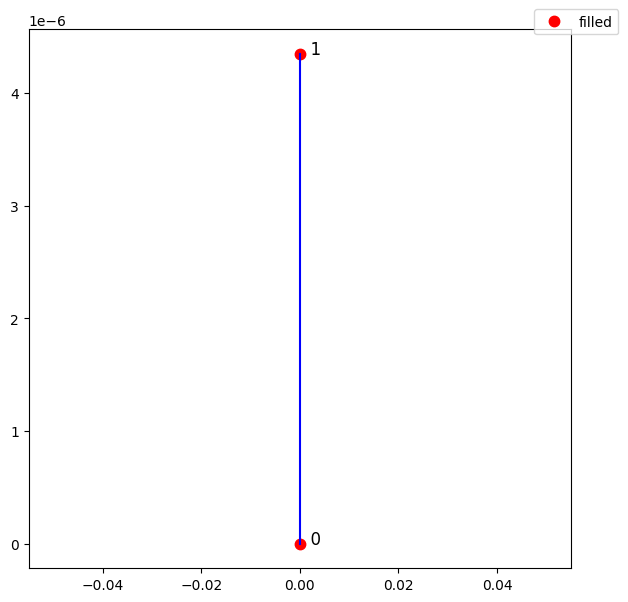

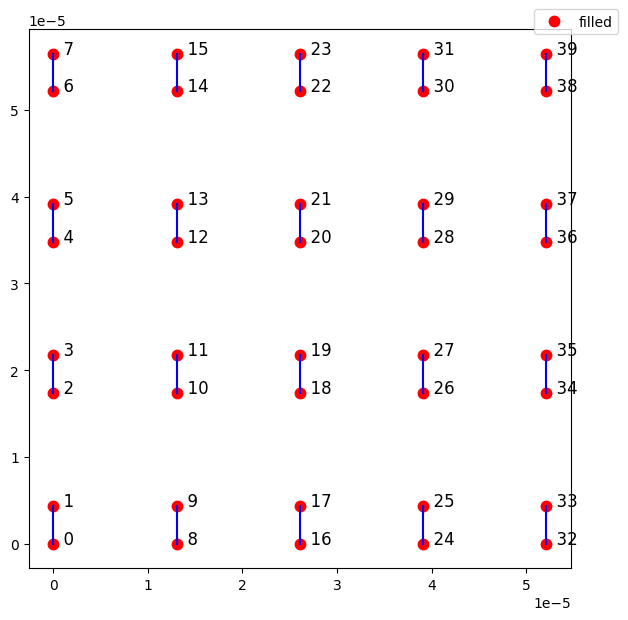

In [7]:
# Take a look at the single register and the parallelized register.

show_register(two_leg_ladder, blockade_radius= Rb)
show_register(parallel_two_leg_ladder, blockade_radius= Rb)

In [ ]:
# We won't actually run this at the moment because a 40-atom configuration is far beyond the capabilities
#  of classical computers to simulate. In the next notebook, we will look at how to set up runs on Aquila (QuEra QPU)
#  and run/analyze this parallelized arrangement.